In [1]:
from enum import Enum

import pandas as pd
import numpy as np

import os
import cv2
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import csv
%matplotlib inline

from PIL import Image
import gc

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [2]:
import torch
import torchvision
import tarfile
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt

from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets.utils import download_url

In [3]:
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient

In [4]:
# Setting up the data from the bucket

connection_string = os.getenv('AZURE_CONNECTION_STRING')
container_train_name = "epitech-zoidberg-dataset-train"
container_val_name = "epitech-zoidberg-dataset-validation"
container_test_name = "epitech-zoidberg-dataset-test"


blob_service_client = BlobServiceClient.from_connection_string(connection_string)

In [5]:
class EOutput(Enum):
  NEGATIVE = 0
  BACTERIA = 1
  VIRUS = 2

class EDataset(Enum):
  TRAIN = 0
  VALIDATION = 1
  TEST = 2

In [6]:
train_tfms = tt.Compose([
                        #  tt.RandomCrop(250, padding=10, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation([-10, 10]),
                         tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
                         tt.ToTensor(),
                         ])

valid_tfms = tt.ToTensor()

In [7]:
# Download images from Azure Storage Account

def load_blob_from_container(container_name, dataset_type):
    images = []
    labels = []

    container_client = blob_service_client.get_container_client(container_name)
    blobs = container_client.list_blobs()

    for blob in blobs:

        blob_client = blob_service_client.get_blob_client(container_name, blob.name)
        stream = blob_client.download_blob().readall()

        nparr = np.frombuffer(stream, np.uint8)

        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

        if img is None: continue

        img = cv2.resize(img, (200,200))

        if dataset_type == EDataset.TRAIN:
            images.append(
                train_tfms(Image.fromarray(img))
            )
        else:
            images.append(
                valid_tfms(Image.fromarray(img))
            )

        if "bacteria" in blob.name:
            labels.append(EOutput.BACTERIA.value)
            continue

        if "virus" in blob.name:
            labels.append(EOutput.VIRUS.value)
            continue

        labels.append(EOutput.NEGATIVE.value)

    return list(zip(images, labels))

In [8]:
train_ds = load_blob_from_container(container_name=container_train_name, dataset_type=EDataset.TRAIN)
val_ds = load_blob_from_container(container_name=container_val_name, dataset_type=EDataset.VALIDATION)
test_ds = load_blob_from_container(container_name=container_test_name, dataset_type=EDataset.TEST)

In [10]:
print(f"Train dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")
print(f"Test dataset size: {len(test_ds)}")

Train dataset size: 4684
Validation dataset size: 586
Test dataset size: 585


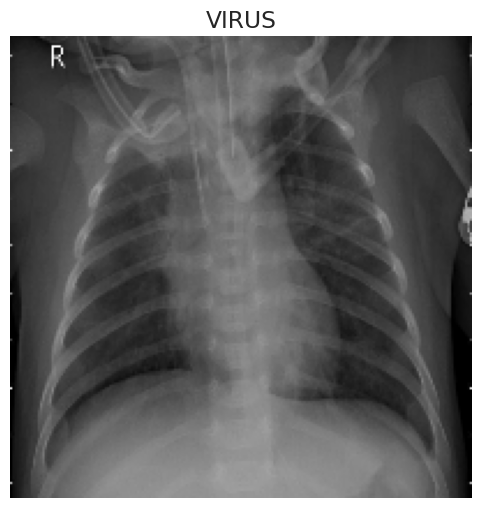

In [11]:
image, label = test_ds[np.random.randint(0, len(test_ds))]

plt.imshow(image.permute(1, 2, 0))
plt.title(EOutput(label).name)
plt.axis('off')
plt.show()

In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [13]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [14]:
def conv_block(in_channels, out_channels, pool=False):
  layers = [
      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, ),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True),
  ]
  if pool: layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

class ResidualBlock(nn.Module):
  def __init__(self, channels):
    super(ResidualBlock, self).__init__()
    self.conv = nn.Sequential(
      conv_block(channels, channels),
      conv_block(channels, channels)
    )

  def forward(self, x):
    return self.conv(x) + x

class ResNet9(ImageClassificationBase):
  def __init__(self, in_channels, num_classes):
    super().__init__()

    self.conv = nn.Sequential(
        conv_block(in_channels, 64),
        conv_block(64, 128, pool=True),
        ResidualBlock(128),

        conv_block(128, 256, pool=True),
        conv_block(256, 512, pool=True),
        ResidualBlock(512),

        nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
    )

  def forward(self, xb):
    return self.conv(xb)

In [15]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):

    torch.cuda.empty_cache()
    history = []

    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []

        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            if grad_clip:
              nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lr'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [27]:
batch_size = 40
input_layer = 200*200

In [28]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, shuffle=True, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [36]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
model = to_device(ResNet9(3, 3), device)
history = [evaluate(model, valid_dl)]
history[0]["train_loss"] = 0

In [37]:
%%time
history += fit_one_cycle(
    epochs=5,
    max_lr=0.01,
    model=model,
    train_loader=train_dl,
    val_loader=valid_dl,
    weight_decay=1e-4,
    grad_clip=.1,
    opt_func=torch.optim.Adam
)

Epoch [0], train_loss: 0.8068, val_loss: 10.2288, val_acc: 0.4684
Epoch [1], train_loss: 0.7853, val_loss: 3.3550, val_acc: 0.2911
Epoch [2], train_loss: 0.6871, val_loss: 0.8123, val_acc: 0.6287
Epoch [3], train_loss: 0.6172, val_loss: 0.7034, val_acc: 0.7256
Epoch [4], train_loss: 0.5486, val_loss: 0.5828, val_acc: 0.7569
CPU times: user 4min 1s, sys: 3min 11s, total: 7min 12s
Wall time: 7min 7s


In [38]:
%%time
history += fit_one_cycle(
    epochs=5,
    max_lr=0.001,
    model=model,
    train_loader=train_dl,
    val_loader=valid_dl,
    weight_decay=1e-4,
    grad_clip=.1,
    opt_func=torch.optim.Adam
)

Epoch [0], train_loss: 0.5286, val_loss: 0.6133, val_acc: 0.7346
Epoch [1], train_loss: 0.5496, val_loss: 0.5883, val_acc: 0.7460
Epoch [2], train_loss: 0.5314, val_loss: 0.5674, val_acc: 0.7338
Epoch [3], train_loss: 0.5107, val_loss: 0.5326, val_acc: 0.7821
Epoch [4], train_loss: 0.4883, val_loss: 0.5207, val_acc: 0.7948
CPU times: user 4min 2s, sys: 3min 12s, total: 7min 15s
Wall time: 7min 9s


In [39]:
%%time
history += fit_one_cycle(
    epochs=5,
    max_lr=0.001,
    model=model,
    train_loader=train_dl,
    val_loader=valid_dl,
    weight_decay=1e-4,
    grad_clip=.1,
    opt_func=torch.optim.Adam
)

Epoch [0], train_loss: 0.4987, val_loss: 1.2575, val_acc: 0.5025
Epoch [1], train_loss: 0.5276, val_loss: 0.6634, val_acc: 0.7221
Epoch [2], train_loss: 0.5128, val_loss: 0.6242, val_acc: 0.7537
Epoch [3], train_loss: 0.5035, val_loss: 0.5253, val_acc: 0.7835
Epoch [4], train_loss: 0.4683, val_loss: 0.5213, val_acc: 0.7965
CPU times: user 3min 59s, sys: 3min 11s, total: 7min 10s
Wall time: 7min 5s


In [40]:
%%time
history += fit_one_cycle(
    epochs=5,
    max_lr=0.0003,
    model=model,
    train_loader=train_dl,
    val_loader=valid_dl,
    weight_decay=1e-4,
    grad_clip=.1,
    opt_func=torch.optim.Adam
)

Epoch [0], train_loss: 0.4651, val_loss: 0.5272, val_acc: 0.7732
Epoch [1], train_loss: 0.4744, val_loss: 0.6310, val_acc: 0.7476
Epoch [2], train_loss: 0.4648, val_loss: 0.5303, val_acc: 0.7839
Epoch [3], train_loss: 0.4407, val_loss: 0.4932, val_acc: 0.8061
Epoch [4], train_loss: 0.4307, val_loss: 0.5140, val_acc: 0.7915
CPU times: user 3min 59s, sys: 3min 14s, total: 7min 14s
Wall time: 7min 9s


In [41]:
%%time
history += fit_one_cycle(
    epochs=5,
    max_lr=0.0001,
    model=model,
    train_loader=train_dl,
    val_loader=valid_dl,
    weight_decay=1e-4,
    grad_clip=.1,
    opt_func=torch.optim.Adam
)

Epoch [0], train_loss: 0.4284, val_loss: 0.4955, val_acc: 0.8061
Epoch [1], train_loss: 0.4397, val_loss: 0.5289, val_acc: 0.7883
Epoch [2], train_loss: 0.4246, val_loss: 0.5127, val_acc: 0.7820
Epoch [3], train_loss: 0.4146, val_loss: 0.4938, val_acc: 0.7931
Epoch [4], train_loss: 0.4068, val_loss: 0.5214, val_acc: 0.7834
CPU times: user 4min 2s, sys: 3min 12s, total: 7min 14s
Wall time: 7min 9s


In [32]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

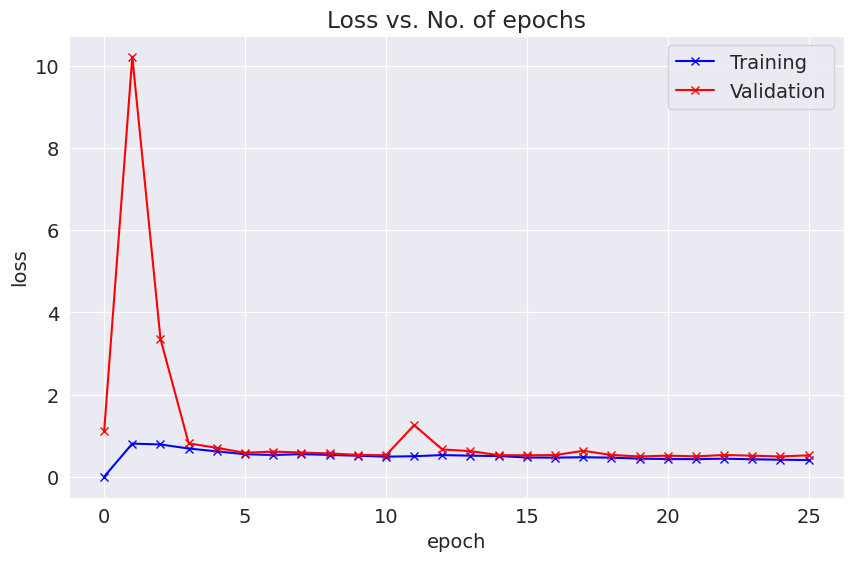

In [42]:
plot_losses(history)

In [108]:
model = model.to("cuda")

Label: BACTERIA, prediction: BACTERIA


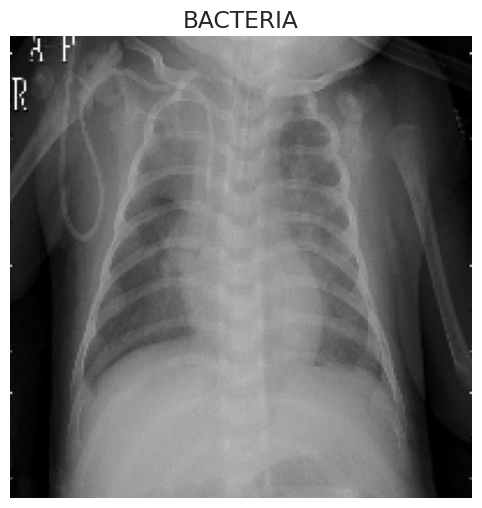

In [65]:
image, label = test_ds[np.random.randint(0, len(test_ds))]

plt.imshow(image.permute(1, 2, 0))
plt.title(EOutput(label).name)

pred = model(to_device(image.unsqueeze(0), device))

print(f"Label: {EOutput(label).name}, prediction: {EOutput(torch.max(pred, dim=1)[1].item()).name}")

plt.axis('off')

plt.show()

In [44]:
# test_dl = DeviceDataLoader(test_dl, device)
result = evaluate(model, test_dl)
print(result)

{'val_loss': 0.476727694272995, 'val_acc': 0.8153334259986877}


In [66]:
file_meta_data = [("val_loss", "val_acc", "train_loss")]
file_data_csv = [(i["val_loss"], i["val_acc"], i["train_loss"]) for i in history]

full_file = file_meta_data + file_data_csv

In [68]:
path = os.path.join(os.getcwd(), "model2_result.csv")
print(path)
with open(path, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(full_file)

/home/dany_leguy/models/model2/model2_result.csv


In [72]:
model_file_name = "model2.pth"
model_path = os.path.join(os.getcwd(), model_file_name)

In [73]:
torch.save(model.state_dict(), model_path)

In [ ]:
model.load_state_dict(torch.load(model_path))

In [74]:
# Checks if you have the permissions to write in this folder.
try:
    with open(os.path.join(os.getcwd(), 'temp.txt'), 'w') as f:
        pass
    print("Write permissions check passed.")
except:
    print("Write permissions check failed.")

Write permissions check passed.
